In [144]:
import tensorflow as tf
import numpy as np
import pandas as pd
from time import time
import matplotlib
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
from sklearn.decomposition import PCA
tf.keras.backend.set_floatx('float64')
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
%matplotlib inline
print("tensorflow version: ", tf.__version__)
print("numpy version: ", np.__version__)
print("matplotlib version: ", matplotlib.__version__)
print("sklearn version: ", sklearn.__version__)

tensorflow version:  2.2.0
numpy version:  1.18.1
matplotlib version:  3.1.1
sklearn version:  0.21.3


<center> <h1> Creating the utils for the project</h1>

<b>Autor:</b> Edwin Rueda <br>
<b>email:</b> ejrueda95g@gmail.com <br>
<b>github:</b> https://github.com/ejrueda <br>
<b>website:</b> http://edwinrueda.com/

### scaler
- The scaler class make a minmaxscaler operation in a dataframe, this allows that the dataframe keep your index.
- Parameters:
    - xmin: the min value of the scale
    - xmax: the max value of the scale
- Equation:
    - this scaling is computed by:
$$X_{nov} = \frac{x-min(x)}{max(x) - min(x)} *(x_{max}-x_{min}) + x_{min}$$      

    where $x$ represents the dataframe, and $min(x)$ and $max(x)$, represents the minimum and maximum values per column in the dataframe.

In [2]:
class scaler:
    def __init__(self, xmin, xmax):
        """
        minmax scaler from dataframe
        """
        self.xmin = xmin
        self.xmax = xmax
        self.min_data = False
        self.max_data = False
        self.flag = False
        
    def fit(self, X):
        self.min_data = np.min(X).values
        self.max_data = np.max(X).values
        self.flag = True
        
    def transform(self, X):
        assert self.flag, "Erro de treinamento, primeiro tem que treinar o Scaler, called .fit()"
        X_r = X.copy()
        X_r = ((X_r - self.min_data)/(self.max_data - self.min_data))*(self.xmax-self.xmin) + self.xmin
        return X_r
    
    def inverse_transform(self, X):
        assert self.flag, "Erro de treinamento, primeiro tem que treinar o Scaler, called .fit()"
        X_r = X.copy()
        X_r = ((X_r - self.xmin)*(self.max_data - self.min_data)/(self.xmax - self.xmin)) + self.min_data
        return X_r

### Gan utils
- Gan utils is the class to create, train and evaluate the performance of a GAN architecture.

- functions:
    - <b>train_gan:</b> this fuction combine the generator and discriminator networks and train the gan architecture. Note that this utils implements the tensorflow library, therefore, the G and D networks are not compiled, you just have to pass the networks without compile.
        - <b>parameters:</b>
            - <b>dataset:</b> a dataset to train the gan architecture, must be a tensorflow dataset.
            - <b>G:</b> generator model without training.
            - <b>D:</b> discriminator model without training.
            - <b>epochs:</b> number of epochs to train de gan architecture.
            - <b>batch_size:</b> the size of the batach to train de gan architecture.
            - <b>loss_function:</b> the loss funtion, in this case, this architecture must employ the binary_cross_entropy loss function.
        - <b>return:</b>
            - <b>accumulated_g_loss:</b> the generator loss by epochs in the architecture.
            - <b>accumulated_d_loss:</b> the discriminator loss by epochs in the architecture.
    - <b>train_step:</b> this function train the architecture over one batch. Note that this function is a tensorflow function.
        - <b>parameters:</b>
            - <b>sample:</b> batch to train the architecture. this batch must be a tensorflow batch.
            - <b>batch_size:</b> the size of the batch to train the architecture.
            - <b>loss_function:</b> the loss function of the architecture. Note that in these architectures, the loss function must be a binary_cross_entropy function.
            - <b>noise_input:</b> the size of the noise vector to train de generator network.
        - <b>return:</b>
            - <b>gen_los</b>: the batch loss in the generator network.
            - <b>dis_los</b>: the batch loss in the discriminator network.

In [122]:
class gan_utils:
    
    def __init__(self):
        self.accumulated_gloss = []
        self.accumulated_dloss = []
        self.precision = []
        self.recall = []
        self.kl_d = []
        self.X_train = None
        self.G = None
        self.D = None
        self.noise_input = None
    
    @tf.function
    def kl_divergence(self, probability):
        probability = tf.clip_by_value(probability, 1e-5, 1-1e-5)
        return tf.reduce_mean(probability*tf.math.log(probability/(1-probability)))
    
    @tf.function
    def train_step(self, sample, batch_size, loss_function, noise_input, optimizerG, optimizerD):
        noise = tf.random.normal([batch_size, noise_input])
        with tf.GradientTape() as gG, tf.GradientTape() as gD:
            synthetic_data = G(noise, training=True)

            real_output = D(sample, training=True)
            fake_output = D(synthetic_data, training=True)

            gen_loss = my_binary_cross_entropy(fake_output, tf.ones_like(fake_output))
            dis_loss = .5*(my_binary_cross_entropy(real_output, tf.ones_like(real_output)) + my_binary_cross_entropy(fake_output,tf.zeros_like(fake_output)))

        g_generator = gG.gradient(gen_loss, G.trainable_variables)
        g_discriminator = gD.gradient(dis_loss, D.trainable_variables)

        optimizerG.apply_gradients(zip(g_generator, G.trainable_variables))
        optimizerD.apply_gradients(zip(g_discriminator, D.trainable_variables))

        return gen_loss, dis_loss
    
    def train(self, dataset, G, D, noise_input, epochs, batch_size, loss_function, optimizerG, optimizerD):
        #reset metrics
        self.accumulated_gloss = []
        self.accumulated_dloss = []
        self.precision = []
        self.recall = []
        self.kld = []
        batch_g_loss = []
        batch_d_loss = []
        self.G, self.D = G, D
        self.noise_input = noise_input
        self.X_train = dataset
        batches = tf.data.Dataset.from_tensor_slices(dataset).batch(batch_size)
        for epoch in range(epochs):
            t_i = time()
            for batch in batches:
                batch_g_loss, batch_d_loss = self.train_step(batch, batch_size, loss_function, noise_input,
                                                             optimizerG, optimizerD)
            self.accumulated_dloss.append(tf.reduce_mean(batch_d_loss))
            self.accumulated_gloss.append(tf.reduce_mean(batch_g_loss))

            X_sint = G(tf.random_normal_initializer(mean=0.0, stddev=1)([batch_size,noise_input],
                                                                        dtype=tf.float64))
            X_comb = tf.concat([dataset, X_sint], axis=0)
            y_comb = tf.concat([tf.ones((dataset.shape[0],1)), np.zeros((X_sint.shape[0],1))], axis=0)
            y_proba = D(X_comb)
            y_predict = tf.reshape((tf.greater(y_proba, .5).numpy()*1), [-1])
            self.kl_d.append(self.kl_divergence(y_proba).numpy())
            self.precision.append(precision_score(y_comb.numpy(), y_predict.numpy()))
            self.recall.append(recall_score(y_comb.numpy(), y_predict.numpy()))
            t_f = time()
            
            print("epochs[%d:%d] :: G_loss[%f] :: D_loss[%f] :: time:%f[s]"%(epoch, epochs,
                                                                             self.accumulated_gloss[-1],
                                                                             self.accumulated_dloss[-1],
                                                                             t_f-t_i))
        return self.accumulated_gloss, self.accumulated_dloss
        
    def plot_results(self):
        fig = plt.figure(figsize=(15,10))
        for i in range(4):
            plt.subplot(2,2, i+1)
            if i==0:
                rr = range(0,len(gloss), 3)
                short_g_loss = [self.accumulated_gloss[i] for i in rr]
                short_d_loss = [self.accumulated_dloss[i] for i in rr]
                plt.plot(rr, short_g_loss, label="Generator", color="#FFB248")
                plt.plot(rr, short_d_loss, label="Discriminator", color="#5F84B4")
                plt.xlabel("Epochs", fontsize=13)
                plt.ylabel("Loss", fontsize=13)
                plt.grid(axis="y")
                plt.legend();
            elif i==1:
                plt.title("Divergencia de Kullback-Leibler", fontsize=14)
                plt.plot(range(len(self.kl_d)), self.kl_d, linewidth=.5)
                plt.plot(range(len(self.kl_d)), np.zeros(len(self.kl_d)))
                plt.grid()
                plt.xlabel("Epochs");
                plt.ylabel("Divergencia de Kullback-Leibler");
            elif i==2:
                short_precision = [self.precision[i] for i in rr]
                plt.plot(range(len(short_precision)), short_precision, linewidth=.8, label="precision")
                plt.grid(axis="y")
                plt.plot(range(len(short_precision)), np.ones(len(short_precision))*.5,
                         label="target", linestyle="--")
                plt.legend();
            elif i==3:
                pca = PCA(n_components=2)
                X_real_pca = pca.fit_transform(self.X_train.numpy())
                noise = tf.random.normal([300, self.noise_input])
                synthetics = self.G(noise)
                X_fake_pca = pca.transform(synthetics.numpy())
                plt.scatter(X_fake_pca[:,0], X_fake_pca[:,1], label="synthetic", alpha=.4, color="orange",
                           edgecolors="red");
                plt.scatter(X_real_pca[:,0], X_real_pca[:,1], label="real", marker="*", s=80, color="green",
                            edgecolors="black");
        return fig


###  Test

In [123]:
data = pd.read_csv("../data/all_counts_9_norm_rpkm_log2_preprocessed.csv",
                  index_col=0)
r_g = open("../data/reference_genes.txt").read().splitlines()
r_g.remove("idnT")
X_train = data.loc[r_g]
X_train.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,5.903687,5.879490,5.873191,5.735536,6.016590,6.328393,6.315338,6.504277,6.577601
hcaT,5.692781,5.733848,5.686571,5.925712,6.290692,6.131968,6.113390,5.891730,5.822536
rrsA,10.498560,10.775182,11.515848,11.819169,11.745607,11.033925,10.521316,8.685239,10.590185
ihfB,11.625723,11.784312,12.694811,13.119308,13.096534,12.574847,12.140031,10.126885,11.298441
ssrA,12.889916,13.026561,13.839784,14.807551,14.601034,13.858224,14.509441,12.713618,13.816964


In [124]:
obj_scaler = scaler(xmin=-1, xmax=1)
obj_scaler.fit(X_train)
X_train = obj_scaler.transform(X_train)
X_train.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-1.000000,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959573,-1.000000,-1.000000,-1.000000,-1.000000
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.155035,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044212,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266109,0.174393,0.219843,-0.010831,0.155377


In [125]:
X_train = tf.Variable(np.array(X_train))

In [126]:
noise_input = 50

In [127]:
@tf.function
def my_binary_cross_entropy(prediction, target):
    """
    compute the loss for binary clasification problems
    """
    prediction = tf.clip_by_value(prediction, 1e-5, 1-1e-5)
    return -tf.reduce_mean(target*tf.math.log(prediction) + (1-target)*tf.math.log(1-prediction))

In [128]:
G = Sequential()
G.add(Dense(noise_input, input_shape=(noise_input,)))
G.add(Dense(32)) #64
G.add(tf.keras.layers.Dropout(.1))
G.add(Dense(64)) #64
G.add(tf.keras.layers.Dropout(.15))
G.add(Dense(32))
G.add(Dense(9, activation="tanh"))

D = Sequential()
D.add(Dense(9, input_shape=(9,)))
D.add(Dense(32))
D.add(tf.keras.layers.LeakyReLU(alpha=.2)) #función rectificadora
D.add(tf.keras.layers.Dropout(.1))
D.add(Dense(32))
#D.add(tf.keras.layers.Dropout(.1))
D.add(Dense(1, activation='sigmoid'))

In [129]:
noise = tf.random_normal_initializer(mean=0.0, stddev=1)([1,noise_input], dtype=tf.float64)
print("shape of the input noise:", noise.shape)
synthetic_sample = G(noise)
print("shape of the synthetic sample:", synthetic_sample.shape)
print("prediction of the D network:", D(synthetic_sample))
print("loss of the D network:", my_binary_cross_entropy(D(synthetic_sample), 0))

shape of the input noise: (1, 50)
shape of the synthetic sample: (1, 9)
prediction of the D network: tf.Tensor([[0.39559288]], shape=(1, 1), dtype=float64)
loss of the D network: tf.Tensor(0.5035072685278407, shape=(), dtype=float64)


In [130]:
batch_size = 20
ep = 1700
#optimizerG = tf.optimizers.SGD(lr=0.00014, momentum=0.92, decay=0.00014/ep)
#optimizerD = tf.optimizers.SGD(lr=0.0011, momentum=0.9, decay=0.0011/ep)

optimizerG = tf.optimizers.SGD(lr=0.00015, momentum=0.92, decay=0.00015/ep)
optimizerD = tf.optimizers.SGD(lr=0.0011, momentum=0.9, decay=0.0011/ep)

In [131]:
utils = gan_utils()
gloss, dloss = utils.train(X_train, G, D, noise_input, ep, batch_size, my_binary_cross_entropy, optimizerG, optimizerD)

epochs[0:1700] :: G_loss[0.893794] :: D_loss[0.707943] :: time:0.829583[s]
epochs[1:1700] :: G_loss[0.935403] :: D_loss[0.726991] :: time:0.011072[s]
epochs[2:1700] :: G_loss[0.888085] :: D_loss[0.734712] :: time:0.011000[s]
epochs[3:1700] :: G_loss[0.826508] :: D_loss[0.745307] :: time:0.010952[s]
epochs[4:1700] :: G_loss[0.837059] :: D_loss[0.743461] :: time:0.010745[s]
epochs[5:1700] :: G_loss[0.883911] :: D_loss[0.720377] :: time:0.010760[s]
epochs[6:1700] :: G_loss[0.762564] :: D_loss[0.764838] :: time:0.010889[s]
epochs[7:1700] :: G_loss[0.855735] :: D_loss[0.714335] :: time:0.010722[s]
epochs[8:1700] :: G_loss[0.855117] :: D_loss[0.752557] :: time:0.010754[s]
epochs[9:1700] :: G_loss[0.835200] :: D_loss[0.737874] :: time:0.010858[s]
epochs[10:1700] :: G_loss[0.844550] :: D_loss[0.748832] :: time:0.010916[s]
epochs[11:1700] :: G_loss[0.878791] :: D_loss[0.686475] :: time:0.010888[s]
epochs[12:1700] :: G_loss[0.856574] :: D_loss[0.733546] :: time:0.011198[s]
epochs[13:1700] :: G_l

epochs[109:1700] :: G_loss[0.723030] :: D_loss[0.659140] :: time:0.013838[s]
epochs[110:1700] :: G_loss[0.754909] :: D_loss[0.638489] :: time:0.019101[s]
epochs[111:1700] :: G_loss[0.722579] :: D_loss[0.661163] :: time:0.016300[s]
epochs[112:1700] :: G_loss[0.716521] :: D_loss[0.650010] :: time:0.015817[s]
epochs[113:1700] :: G_loss[0.767764] :: D_loss[0.598356] :: time:0.011405[s]
epochs[114:1700] :: G_loss[0.760595] :: D_loss[0.641462] :: time:0.011180[s]
epochs[115:1700] :: G_loss[0.780966] :: D_loss[0.615381] :: time:0.010938[s]
epochs[116:1700] :: G_loss[0.763872] :: D_loss[0.634907] :: time:0.010854[s]
epochs[117:1700] :: G_loss[0.785928] :: D_loss[0.626601] :: time:0.011143[s]
epochs[118:1700] :: G_loss[0.788309] :: D_loss[0.609601] :: time:0.010754[s]
epochs[119:1700] :: G_loss[0.770792] :: D_loss[0.612511] :: time:0.010929[s]
epochs[120:1700] :: G_loss[0.753041] :: D_loss[0.639011] :: time:0.010860[s]
epochs[121:1700] :: G_loss[0.727287] :: D_loss[0.658743] :: time:0.010827[s]

epochs[219:1700] :: G_loss[0.780573] :: D_loss[0.641983] :: time:0.011464[s]
epochs[220:1700] :: G_loss[0.728282] :: D_loss[0.656138] :: time:0.013807[s]
epochs[221:1700] :: G_loss[0.817350] :: D_loss[0.589922] :: time:0.011467[s]
epochs[222:1700] :: G_loss[0.825562] :: D_loss[0.583328] :: time:0.011047[s]
epochs[223:1700] :: G_loss[0.770729] :: D_loss[0.639742] :: time:0.011090[s]
epochs[224:1700] :: G_loss[0.740620] :: D_loss[0.625860] :: time:0.010847[s]
epochs[225:1700] :: G_loss[0.876837] :: D_loss[0.555282] :: time:0.010782[s]
epochs[226:1700] :: G_loss[0.805942] :: D_loss[0.625711] :: time:0.011151[s]
epochs[227:1700] :: G_loss[0.833355] :: D_loss[0.571494] :: time:0.010696[s]
epochs[228:1700] :: G_loss[0.818769] :: D_loss[0.587557] :: time:0.010990[s]
epochs[229:1700] :: G_loss[0.862906] :: D_loss[0.587506] :: time:0.010844[s]
epochs[230:1700] :: G_loss[0.840901] :: D_loss[0.575870] :: time:0.010979[s]
epochs[231:1700] :: G_loss[0.882866] :: D_loss[0.567775] :: time:0.010755[s]

epochs[330:1700] :: G_loss[0.822563] :: D_loss[0.600492] :: time:0.010921[s]
epochs[331:1700] :: G_loss[0.901833] :: D_loss[0.583620] :: time:0.013458[s]
epochs[332:1700] :: G_loss[0.849528] :: D_loss[0.558327] :: time:0.011688[s]
epochs[333:1700] :: G_loss[1.033563] :: D_loss[0.529876] :: time:0.011189[s]
epochs[334:1700] :: G_loss[0.788260] :: D_loss[0.628286] :: time:0.011282[s]
epochs[335:1700] :: G_loss[0.946201] :: D_loss[0.567124] :: time:0.010887[s]
epochs[336:1700] :: G_loss[0.905158] :: D_loss[0.586103] :: time:0.010878[s]
epochs[337:1700] :: G_loss[0.975937] :: D_loss[0.528387] :: time:0.010954[s]
epochs[338:1700] :: G_loss[0.890405] :: D_loss[0.573938] :: time:0.010739[s]
epochs[339:1700] :: G_loss[0.858290] :: D_loss[0.561827] :: time:0.010715[s]
epochs[340:1700] :: G_loss[0.873740] :: D_loss[0.615053] :: time:0.010778[s]
epochs[341:1700] :: G_loss[0.819012] :: D_loss[0.624923] :: time:0.010776[s]
epochs[342:1700] :: G_loss[0.956811] :: D_loss[0.573481] :: time:0.010788[s]

epochs[438:1700] :: G_loss[0.934489] :: D_loss[0.547748] :: time:0.011369[s]
epochs[439:1700] :: G_loss[0.858761] :: D_loss[0.587162] :: time:0.016990[s]
epochs[440:1700] :: G_loss[0.939678] :: D_loss[0.558816] :: time:0.012691[s]
epochs[441:1700] :: G_loss[0.939505] :: D_loss[0.565444] :: time:0.011106[s]
epochs[442:1700] :: G_loss[0.754152] :: D_loss[0.641585] :: time:0.011021[s]
epochs[443:1700] :: G_loss[0.840758] :: D_loss[0.624814] :: time:0.010827[s]
epochs[444:1700] :: G_loss[1.016222] :: D_loss[0.537060] :: time:0.010771[s]
epochs[445:1700] :: G_loss[0.960171] :: D_loss[0.559011] :: time:0.010890[s]
epochs[446:1700] :: G_loss[0.943186] :: D_loss[0.574271] :: time:0.010739[s]
epochs[447:1700] :: G_loss[0.836777] :: D_loss[0.646192] :: time:0.010841[s]
epochs[448:1700] :: G_loss[0.836805] :: D_loss[0.620770] :: time:0.010890[s]
epochs[449:1700] :: G_loss[1.040818] :: D_loss[0.517852] :: time:0.010756[s]
epochs[450:1700] :: G_loss[0.964876] :: D_loss[0.572173] :: time:0.010834[s]

epochs[551:1700] :: G_loss[1.062587] :: D_loss[0.545897] :: time:0.012472[s]
epochs[552:1700] :: G_loss[0.849215] :: D_loss[0.606427] :: time:0.012447[s]
epochs[553:1700] :: G_loss[0.899218] :: D_loss[0.559099] :: time:0.011124[s]
epochs[554:1700] :: G_loss[0.953924] :: D_loss[0.573659] :: time:0.011225[s]
epochs[555:1700] :: G_loss[0.843713] :: D_loss[0.612842] :: time:0.010835[s]
epochs[556:1700] :: G_loss[0.956043] :: D_loss[0.558185] :: time:0.010855[s]
epochs[557:1700] :: G_loss[0.815891] :: D_loss[0.633192] :: time:0.010859[s]
epochs[558:1700] :: G_loss[0.962139] :: D_loss[0.561667] :: time:0.010896[s]
epochs[559:1700] :: G_loss[0.860667] :: D_loss[0.588555] :: time:0.010727[s]
epochs[560:1700] :: G_loss[0.855765] :: D_loss[0.590711] :: time:0.010858[s]
epochs[561:1700] :: G_loss[0.957189] :: D_loss[0.557135] :: time:0.010916[s]
epochs[562:1700] :: G_loss[0.858523] :: D_loss[0.604695] :: time:0.010843[s]
epochs[563:1700] :: G_loss[0.970443] :: D_loss[0.548424] :: time:0.010876[s]

epochs[659:1700] :: G_loss[0.917850] :: D_loss[0.565815] :: time:0.010991[s]
epochs[660:1700] :: G_loss[0.987742] :: D_loss[0.566248] :: time:0.014408[s]
epochs[661:1700] :: G_loss[0.920111] :: D_loss[0.590179] :: time:0.011420[s]
epochs[662:1700] :: G_loss[0.820547] :: D_loss[0.637727] :: time:0.011171[s]
epochs[663:1700] :: G_loss[0.851495] :: D_loss[0.653051] :: time:0.011341[s]
epochs[664:1700] :: G_loss[1.033325] :: D_loss[0.556353] :: time:0.010829[s]
epochs[665:1700] :: G_loss[1.066799] :: D_loss[0.582995] :: time:0.010795[s]
epochs[666:1700] :: G_loss[0.855759] :: D_loss[0.609519] :: time:0.010751[s]
epochs[667:1700] :: G_loss[0.813571] :: D_loss[0.584346] :: time:0.010811[s]
epochs[668:1700] :: G_loss[0.898619] :: D_loss[0.568819] :: time:0.010927[s]
epochs[669:1700] :: G_loss[0.898915] :: D_loss[0.595425] :: time:0.011431[s]
epochs[670:1700] :: G_loss[1.001211] :: D_loss[0.549300] :: time:0.010893[s]
epochs[671:1700] :: G_loss[0.992476] :: D_loss[0.539477] :: time:0.010885[s]

epochs[768:1700] :: G_loss[0.859003] :: D_loss[0.645203] :: time:0.013855[s]
epochs[769:1700] :: G_loss[1.026896] :: D_loss[0.592630] :: time:0.013045[s]
epochs[770:1700] :: G_loss[0.796425] :: D_loss[0.658689] :: time:0.011418[s]
epochs[771:1700] :: G_loss[0.901438] :: D_loss[0.631636] :: time:0.011119[s]
epochs[772:1700] :: G_loss[0.827368] :: D_loss[0.603208] :: time:0.010818[s]
epochs[773:1700] :: G_loss[0.903923] :: D_loss[0.593251] :: time:0.010889[s]
epochs[774:1700] :: G_loss[0.890083] :: D_loss[0.615628] :: time:0.010927[s]
epochs[775:1700] :: G_loss[0.848845] :: D_loss[0.624090] :: time:0.010906[s]
epochs[776:1700] :: G_loss[0.884941] :: D_loss[0.639229] :: time:0.010911[s]
epochs[777:1700] :: G_loss[0.884652] :: D_loss[0.625955] :: time:0.010854[s]
epochs[778:1700] :: G_loss[0.829237] :: D_loss[0.606679] :: time:0.010913[s]
epochs[779:1700] :: G_loss[0.806363] :: D_loss[0.644127] :: time:0.010884[s]
epochs[780:1700] :: G_loss[0.930587] :: D_loss[0.615087] :: time:0.010812[s]

epochs[881:1700] :: G_loss[0.955556] :: D_loss[0.615136] :: time:0.011888[s]
epochs[882:1700] :: G_loss[0.797217] :: D_loss[0.648418] :: time:0.013592[s]
epochs[883:1700] :: G_loss[0.898938] :: D_loss[0.647073] :: time:0.011578[s]
epochs[884:1700] :: G_loss[0.878641] :: D_loss[0.622965] :: time:0.011131[s]
epochs[885:1700] :: G_loss[0.864864] :: D_loss[0.649206] :: time:0.011044[s]
epochs[886:1700] :: G_loss[0.866219] :: D_loss[0.638030] :: time:0.010824[s]
epochs[887:1700] :: G_loss[0.769919] :: D_loss[0.648629] :: time:0.010885[s]
epochs[888:1700] :: G_loss[0.835530] :: D_loss[0.631819] :: time:0.010833[s]
epochs[889:1700] :: G_loss[0.772247] :: D_loss[0.705150] :: time:0.011653[s]
epochs[890:1700] :: G_loss[0.874644] :: D_loss[0.636103] :: time:0.010880[s]
epochs[891:1700] :: G_loss[1.019148] :: D_loss[0.599603] :: time:0.010818[s]
epochs[892:1700] :: G_loss[0.878004] :: D_loss[0.625606] :: time:0.010732[s]
epochs[893:1700] :: G_loss[0.834361] :: D_loss[0.642676] :: time:0.011064[s]

epochs[989:1700] :: G_loss[0.819764] :: D_loss[0.639187] :: time:0.011796[s]
epochs[990:1700] :: G_loss[0.955586] :: D_loss[0.609860] :: time:0.013852[s]
epochs[991:1700] :: G_loss[0.854544] :: D_loss[0.670412] :: time:0.012129[s]
epochs[992:1700] :: G_loss[0.726674] :: D_loss[0.692389] :: time:0.011059[s]
epochs[993:1700] :: G_loss[0.705613] :: D_loss[0.697668] :: time:0.011220[s]
epochs[994:1700] :: G_loss[0.878663] :: D_loss[0.625778] :: time:0.010869[s]
epochs[995:1700] :: G_loss[0.758995] :: D_loss[0.672077] :: time:0.010994[s]
epochs[996:1700] :: G_loss[0.813288] :: D_loss[0.649889] :: time:0.010955[s]
epochs[997:1700] :: G_loss[0.834184] :: D_loss[0.650212] :: time:0.010885[s]
epochs[998:1700] :: G_loss[0.714994] :: D_loss[0.677311] :: time:0.010878[s]
epochs[999:1700] :: G_loss[0.847446] :: D_loss[0.623444] :: time:0.011191[s]
epochs[1000:1700] :: G_loss[0.876983] :: D_loss[0.643282] :: time:0.010952[s]
epochs[1001:1700] :: G_loss[0.826336] :: D_loss[0.679070] :: time:0.010853[

epochs[1097:1700] :: G_loss[0.748879] :: D_loss[0.673441] :: time:0.012625[s]
epochs[1098:1700] :: G_loss[0.889976] :: D_loss[0.667993] :: time:0.016035[s]
epochs[1099:1700] :: G_loss[0.781024] :: D_loss[0.656561] :: time:0.011627[s]
epochs[1100:1700] :: G_loss[0.820735] :: D_loss[0.631991] :: time:0.011107[s]
epochs[1101:1700] :: G_loss[0.790374] :: D_loss[0.666949] :: time:0.010966[s]
epochs[1102:1700] :: G_loss[0.760486] :: D_loss[0.679877] :: time:0.011054[s]
epochs[1103:1700] :: G_loss[0.769913] :: D_loss[0.683819] :: time:0.010984[s]
epochs[1104:1700] :: G_loss[0.776889] :: D_loss[0.671491] :: time:0.010864[s]
epochs[1105:1700] :: G_loss[0.842645] :: D_loss[0.655173] :: time:0.010841[s]
epochs[1106:1700] :: G_loss[0.828083] :: D_loss[0.657156] :: time:0.010966[s]
epochs[1107:1700] :: G_loss[0.765028] :: D_loss[0.664244] :: time:0.011068[s]
epochs[1108:1700] :: G_loss[0.734538] :: D_loss[0.690894] :: time:0.011093[s]
epochs[1109:1700] :: G_loss[0.732937] :: D_loss[0.716020] :: tim

epochs[1206:1700] :: G_loss[0.754726] :: D_loss[0.659670] :: time:0.013935[s]
epochs[1207:1700] :: G_loss[0.773656] :: D_loss[0.688489] :: time:0.011864[s]
epochs[1208:1700] :: G_loss[0.759169] :: D_loss[0.688696] :: time:0.011106[s]
epochs[1209:1700] :: G_loss[0.747179] :: D_loss[0.696855] :: time:0.011022[s]
epochs[1210:1700] :: G_loss[0.780724] :: D_loss[0.649989] :: time:0.010751[s]
epochs[1211:1700] :: G_loss[0.788657] :: D_loss[0.697514] :: time:0.010858[s]
epochs[1212:1700] :: G_loss[0.854137] :: D_loss[0.617845] :: time:0.011088[s]
epochs[1213:1700] :: G_loss[0.830484] :: D_loss[0.641214] :: time:0.010944[s]
epochs[1214:1700] :: G_loss[0.743816] :: D_loss[0.695727] :: time:0.010926[s]
epochs[1215:1700] :: G_loss[0.708162] :: D_loss[0.715584] :: time:0.010853[s]
epochs[1216:1700] :: G_loss[0.788372] :: D_loss[0.669318] :: time:0.010948[s]
epochs[1217:1700] :: G_loss[0.835182] :: D_loss[0.677406] :: time:0.010914[s]
epochs[1218:1700] :: G_loss[0.691938] :: D_loss[0.691166] :: tim

epochs[1317:1700] :: G_loss[0.713585] :: D_loss[0.681682] :: time:0.012888[s]
epochs[1318:1700] :: G_loss[0.720136] :: D_loss[0.684504] :: time:0.013140[s]
epochs[1319:1700] :: G_loss[0.741847] :: D_loss[0.675233] :: time:0.011585[s]
epochs[1320:1700] :: G_loss[0.729037] :: D_loss[0.684044] :: time:0.011250[s]
epochs[1321:1700] :: G_loss[0.772584] :: D_loss[0.690156] :: time:0.011276[s]
epochs[1322:1700] :: G_loss[0.748830] :: D_loss[0.674317] :: time:0.010959[s]
epochs[1323:1700] :: G_loss[0.747768] :: D_loss[0.679380] :: time:0.010802[s]
epochs[1324:1700] :: G_loss[0.823880] :: D_loss[0.636580] :: time:0.010861[s]
epochs[1325:1700] :: G_loss[0.799597] :: D_loss[0.654465] :: time:0.010796[s]
epochs[1326:1700] :: G_loss[0.749112] :: D_loss[0.677971] :: time:0.010827[s]
epochs[1327:1700] :: G_loss[0.773865] :: D_loss[0.657653] :: time:0.010754[s]
epochs[1328:1700] :: G_loss[0.764105] :: D_loss[0.652376] :: time:0.010981[s]
epochs[1329:1700] :: G_loss[0.793260] :: D_loss[0.655600] :: tim

epochs[1425:1700] :: G_loss[0.736655] :: D_loss[0.696247] :: time:0.011548[s]
epochs[1426:1700] :: G_loss[0.760712] :: D_loss[0.669157] :: time:0.013348[s]
epochs[1427:1700] :: G_loss[0.780884] :: D_loss[0.673030] :: time:0.014387[s]
epochs[1428:1700] :: G_loss[0.813333] :: D_loss[0.649384] :: time:0.011071[s]
epochs[1429:1700] :: G_loss[0.805571] :: D_loss[0.643463] :: time:0.011262[s]
epochs[1430:1700] :: G_loss[0.797177] :: D_loss[0.637119] :: time:0.010963[s]
epochs[1431:1700] :: G_loss[0.715531] :: D_loss[0.685964] :: time:0.010827[s]
epochs[1432:1700] :: G_loss[0.812134] :: D_loss[0.631101] :: time:0.010958[s]
epochs[1433:1700] :: G_loss[0.771513] :: D_loss[0.672338] :: time:0.010997[s]
epochs[1434:1700] :: G_loss[0.755731] :: D_loss[0.653712] :: time:0.011037[s]
epochs[1435:1700] :: G_loss[0.816964] :: D_loss[0.647225] :: time:0.010938[s]
epochs[1436:1700] :: G_loss[0.762292] :: D_loss[0.670365] :: time:0.012675[s]
epochs[1437:1700] :: G_loss[0.772750] :: D_loss[0.663718] :: tim

epochs[1533:1700] :: G_loss[0.732029] :: D_loss[0.656348] :: time:0.015756[s]
epochs[1534:1700] :: G_loss[0.736457] :: D_loss[0.680475] :: time:0.014517[s]
epochs[1535:1700] :: G_loss[0.744280] :: D_loss[0.690129] :: time:0.011753[s]
epochs[1536:1700] :: G_loss[0.807894] :: D_loss[0.642547] :: time:0.011169[s]
epochs[1537:1700] :: G_loss[0.799348] :: D_loss[0.664913] :: time:0.010958[s]
epochs[1538:1700] :: G_loss[0.716699] :: D_loss[0.702807] :: time:0.010923[s]
epochs[1539:1700] :: G_loss[0.772562] :: D_loss[0.663563] :: time:0.010941[s]
epochs[1540:1700] :: G_loss[0.775912] :: D_loss[0.654847] :: time:0.010903[s]
epochs[1541:1700] :: G_loss[0.787569] :: D_loss[0.655780] :: time:0.010804[s]
epochs[1542:1700] :: G_loss[0.847437] :: D_loss[0.639068] :: time:0.010975[s]
epochs[1543:1700] :: G_loss[0.750354] :: D_loss[0.672314] :: time:0.010879[s]
epochs[1544:1700] :: G_loss[0.772095] :: D_loss[0.641239] :: time:0.010803[s]
epochs[1545:1700] :: G_loss[0.768714] :: D_loss[0.693453] :: tim

epochs[1641:1700] :: G_loss[0.696556] :: D_loss[0.699467] :: time:0.013088[s]
epochs[1642:1700] :: G_loss[0.834790] :: D_loss[0.662354] :: time:0.013615[s]
epochs[1643:1700] :: G_loss[0.786321] :: D_loss[0.654437] :: time:0.012159[s]
epochs[1644:1700] :: G_loss[0.760817] :: D_loss[0.674477] :: time:0.011383[s]
epochs[1645:1700] :: G_loss[0.780720] :: D_loss[0.657601] :: time:0.010934[s]
epochs[1646:1700] :: G_loss[0.691791] :: D_loss[0.711248] :: time:0.010898[s]
epochs[1647:1700] :: G_loss[0.702346] :: D_loss[0.707988] :: time:0.011211[s]
epochs[1648:1700] :: G_loss[0.699191] :: D_loss[0.704630] :: time:0.010929[s]
epochs[1649:1700] :: G_loss[0.717055] :: D_loss[0.689122] :: time:0.010981[s]
epochs[1650:1700] :: G_loss[0.785498] :: D_loss[0.633918] :: time:0.010971[s]
epochs[1651:1700] :: G_loss[0.724541] :: D_loss[0.677663] :: time:0.011010[s]
epochs[1652:1700] :: G_loss[0.722925] :: D_loss[0.696911] :: time:0.010932[s]
epochs[1653:1700] :: G_loss[0.752640] :: D_loss[0.669361] :: tim

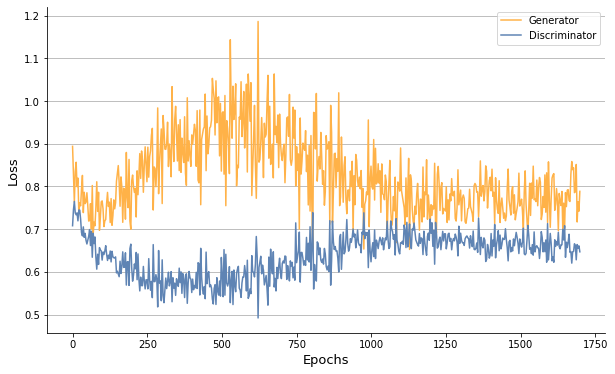

In [132]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
rr = range(0,len(gloss), 3)
short_g_loss = [gloss[i] for i in rr]
short_d_loss = [dloss[i] for i in rr]
#plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.plot(rr, short_g_loss, label="Generator", color="#FFB248")
plt.plot(rr, short_d_loss, label="Discriminator", color="#5F84B4")
plt.xlabel("Epochs", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.grid(axis="y")
plt.legend();

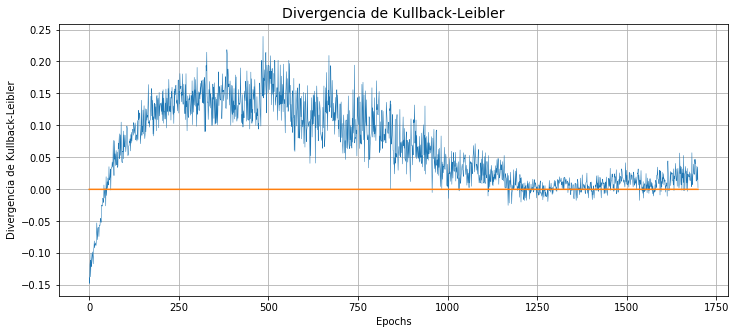

In [133]:
plt.figure(figsize=(12,5))
plt.title("Divergencia de Kullback-Leibler", fontsize=14)
plt.plot(range(len(utils.kl_d)), utils.kl_d, linewidth=.5)
plt.plot(range(len(utils.kl_d)), np.zeros(len(utils.kl_d)))
plt.grid()
plt.xlabel("Epochs");
plt.ylabel("Divergencia de Kullback-Leibler");

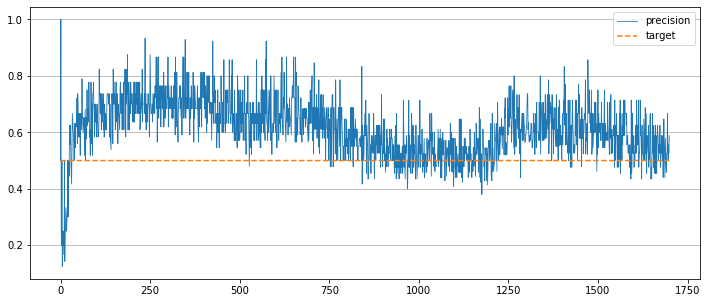

In [134]:
fig = plt.figure(figsize=(12,5))
plt.plot(range(len(utils.precision)), utils.precision, linewidth=.8, label="precision")
plt.grid(axis="y")
plt.plot(range(len(utils.precision)), np.ones(len(utils.precision))*.5, label="target", linestyle="--")
plt.legend();

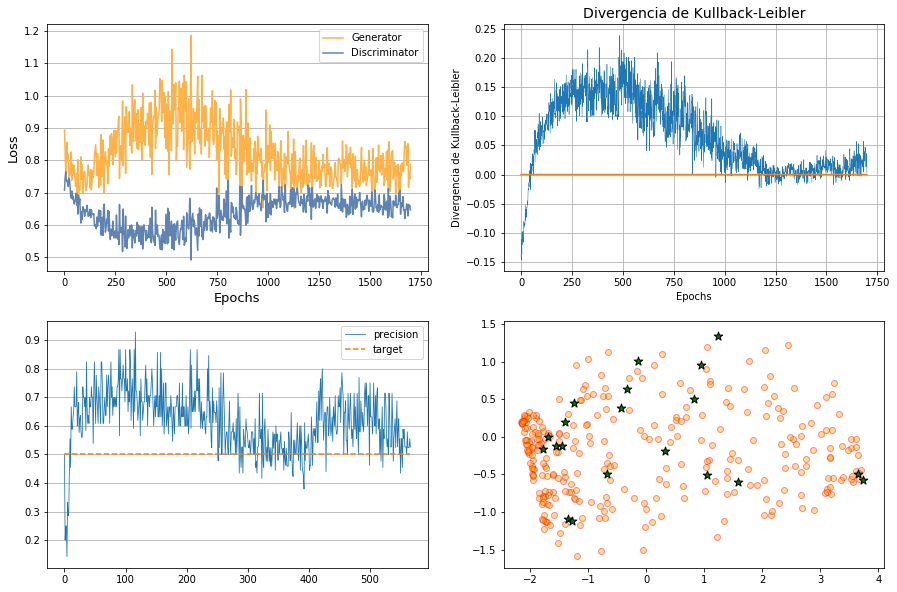

In [135]:
p = utils.plot_results()

In [136]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_real_pca = pca.fit_transform(X_train.numpy())

noise = tf.random.normal([300,noise_input])
synthetics = G(noise)
synthetics.shape
X_fake_pca = pca.transform(synthetics.numpy())

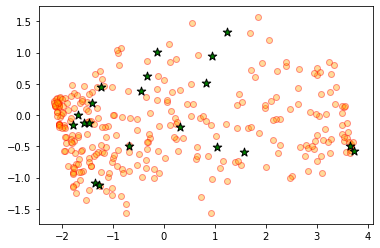

In [137]:
plt.scatter(X_fake_pca[:,0], X_fake_pca[:,1], label="synthetic", alpha=.4, color="orange",
           edgecolors="red");
plt.scatter(X_real_pca[:,0], X_real_pca[:,1], label="real", marker="*", s=80, color="green",
            edgecolors="black");